# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
# Importamos librerias.
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import gzip
from matplotlib import rcParams
from scipy.stats import norm
import gc #garbage collector
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [2]:


def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews**

In [3]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [4]:
data_reviews = pd.DataFrame(data_reviews)

In [5]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


In [6]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

**Games**

In [7]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [8]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [9]:
data_games[data_games.id == '35140']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


# PARTE A - EXPLORACIÓN DE DATOS - Analisis Exploratorio de Datos
# Data Reviews 

* Antes de comenzar a hacer el analisis exploratorio quiero dejar por sentado a que hace referencia cada columna en ambos datasets.

**username**: Nombre del usuario que ha dejado la reseña.

**hours**: Cantidad de horas jugadas (acumuladas) en el juego al cual se le ha hecho la reseña.

**products**: Cantidad de juegos probados.

**product_id**: Identificacion númerica del juego reseñado.

**page_order**: Número de página en el cual se encuentra el juego dentro de la plataforma.

**date**: Fecha en la cual se ha creado la reseña.

**text**: Comentario sobre el juego.

**early_access**: Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo.

**page**: No es interpretable.

**user_id**: Identificación numérica del usuario creador de la reseña.

**found_funny**: Cantidad de calificaciones positivas creadas por otros usuarios.

**compensation**: Variable no interpretable dada la cantidad de valores nulos contenidos en ella.



- Exploración de nulos y algunas columnas que considero interesantes.

In [10]:
# Cargamos el dataset
print('En nuestro archivo tenemos:', data_reviews.shape[0], 'filas y', data_reviews.shape[1], 'columnas.')

En nuestro archivo tenemos: 779307 filas y 12 columnas.


In [11]:
#descripción
data_reviews.head(10)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN
5,Szudof,0.2,155.0,288690,0,2016-08-31,"<23:32:55> ""Pit"": Hello, my name is dominik di...",False,1,NaN,Product received for free,3.0
6,Vonder,2.7,264.0,35600,3,2017-04-15,I like the art style and the idea but what a b...,False,1,76561198113497324,NaN,NaN
7,LucaFox,4.0,136.0,620900,3,2017-09-11,"Very, very good game. I love dungeon crawlers,...",False,1,76561198146674484,NaN,1.0
8,rampage1209,34.8,3.0,1840,4,2018-01-04,WAY PAST COOL,False,1,76561198080474371,NaN,NaN
9,Devil Azite,0.1,548.0,671270,5,2017-07-09,Putting a hat on your head has disasterous rep...,False,1,NaN,Product received for free,1.0


In [12]:
# Pequeño pantallaso
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779307 entries, 0 to 779306
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      779307 non-null  object 
 1   hours         776670 non-null  float64
 2   products      777741 non-null  float64
 3   product_id    779307 non-null  object 
 4   page_order    779307 non-null  int64  
 5   date          779307 non-null  object 
 6   text          779307 non-null  object 
 7   early_access  779307 non-null  bool   
 8   page          779307 non-null  int64  
 9   user_id       317340 non-null  object 
 10  compensation  14588 non-null   object 
 11  found_funny   120164 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 66.1+ MB


In [13]:
# Pequeña descripción de columnas.
data_reviews.describe().round()

,hours,products,page_order,page,found_funny
count,776670.0,777741.0,779307.0,779307.0,120164.0
mean,112.0,237.0,4.0,894.0,8.0
std,390.0,486.0,3.0,1928.0,72.0
min,0.0,1.0,0.0,1.0,1.0
25%,4.0,45.0,2.0,53.0,1.0
50%,15.0,110.0,4.0,238.0,1.0
75%,60.0,246.0,7.0,829.0,3.0
max,28164.0,13540.0,9.0,18371.0,6524.0


* Valores máximos curiosos en hours por ejemplo.
* Demasiados valores nulos.
* Realmente nos sirve Page o Found_funny ?


In [14]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

In [15]:
# Aquí veremos las diferentes columnas con las que contamos y la cantidad de datos faltantes para tener en cuenta en el futuro.
print('Los nombres de las columnas son: ')
print('\n', data_reviews.columns)
print()
miss_values_count = data_reviews.isnull().sum(min_count=1)
miss_values_count = miss_values_count[miss_values_count != 0]
print(f"Número de columnas con datos faltantes: {miss_values_count.shape[0]}")
if miss_values_count.shape[0]:
    print("Recuento de valores nulos por columna: ")
    print()
    for name, miss_vals in miss_values_count.items():
        p = miss_vals > 1
        print(f"  - A la columna '{name}' le falta{'n' if p else ''} "
              f"{miss_vals} dato{'s' if p else ''}.")


Los nombres de las columnas son: 

 Index(['username', 'hours', 'products', 'product_id', 'page_order', 'date',
       'text', 'early_access', 'page', 'user_id', 'compensation',
       'found_funny'],
      dtype='object')

Número de columnas con datos faltantes: 5
Recuento de valores nulos por columna: 

  - A la columna 'hours' le faltan 2637 datos.
  - A la columna 'products' le faltan 1566 datos.
  - A la columna 'user_id' le faltan 461967 datos.
  - A la columna 'compensation' le faltan 764719 datos.
  - A la columna 'found_funny' le faltan 659143 datos.


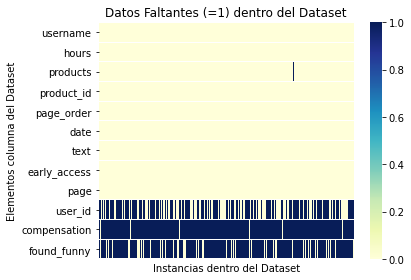

In [16]:
# Mapa de calor donde se observan la cantidad de datos faltantes.
Dat = data_reviews.isnull()
heat = sns.heatmap(Dat.T, cmap = "YlGnBu", xticklabels=False)
plt.title('Datos Faltantes (=1) dentro del Dataset')
plt.xlabel('Instancias dentro del Dataset')
plt.ylabel('Elementos columna del Dataset')
plt.tight_layout()

In [17]:
# estudio de las horas jugadas por reviews. Muy dispareja.
data_reviews.hours.describe().round()

count    776670.0
mean        112.0
std         390.0
min           0.0
25%           4.0
50%          15.0
75%          60.0
max       28164.0
Name: hours, dtype: float64

In [18]:
# cantidad de reviews por producto.
data_reviews["product_id"].value_counts(dropna=False)

440       18373
252490    10221
49520      7321
377160     7113
271590     5976
          ...  
433830        1
652050        1
697700        1
628850        1
563710        1
Name: product_id, Length: 12665, dtype: int64

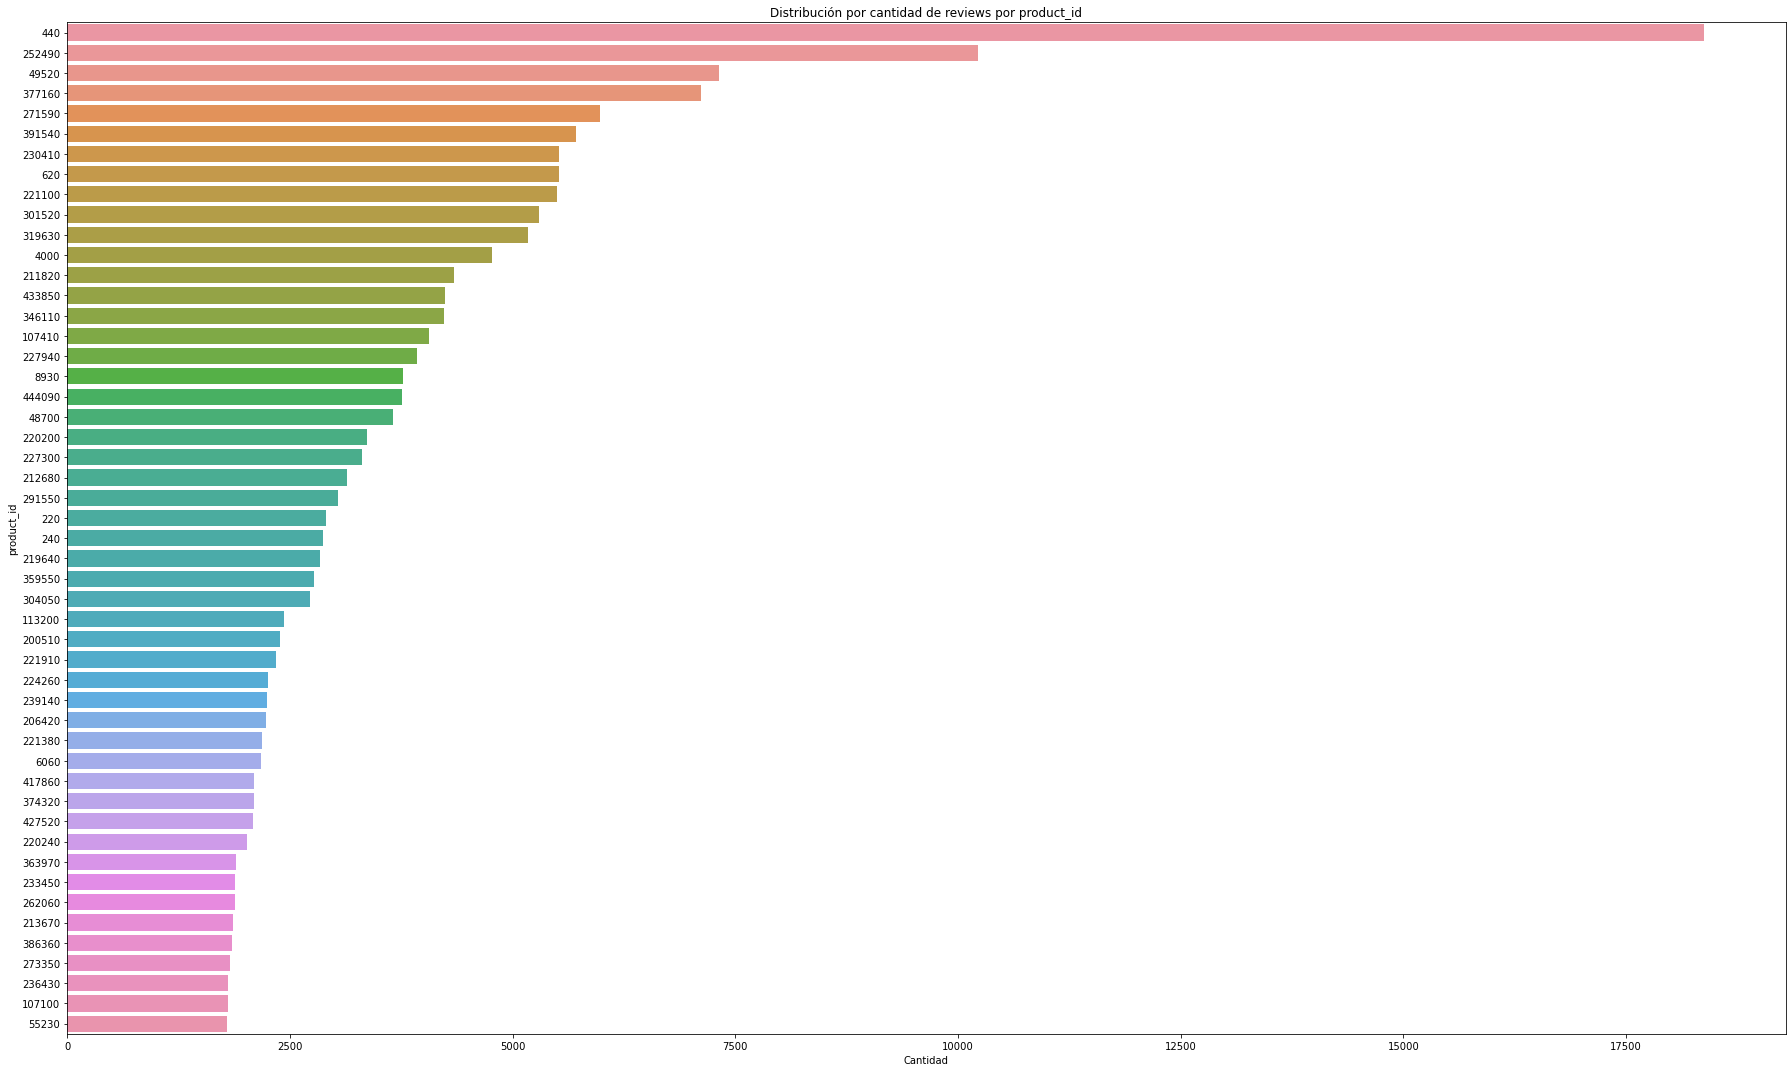

In [19]:
plt.figure(figsize=(25,15))
sns.countplot(data = data_reviews, y = "product_id", order= data_reviews["product_id"].value_counts().index[:50,]) 
plt.title("Distribución por cantidad de reviews por product_id")
plt.xlabel("Cantidad")
plt.ylabel("product_id")
plt.tight_layout()
plt.show()

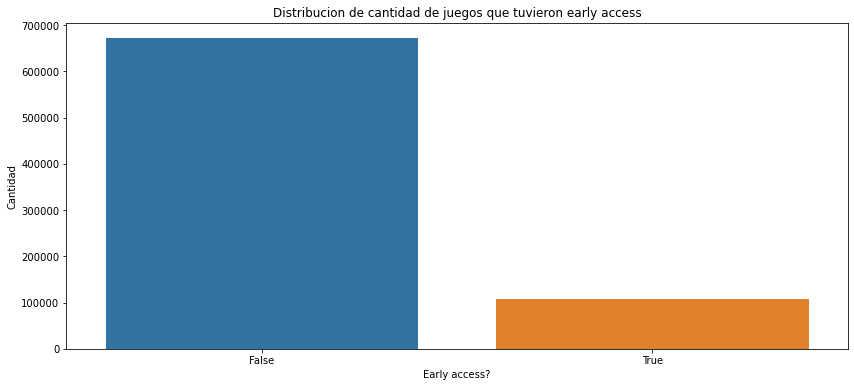

In [20]:
rcParams['figure.figsize'] = 14,6
early = sns.countplot(x = 'early_access', data =data_reviews,
              order = data_reviews['early_access'].value_counts().index)
plt.xlabel("Early access?")
plt.ylabel("Cantidad")
plt.title("Distribucion de cantidad de juegos que tuvieron early access") 
plt.show(early)

* Tomo los primeros dos productos como ejemplo para estudiarlos. Del mismo modo con los últimos dos de estos 50.

In [21]:
# 1ero
data_reviews[data_reviews.product_id == "440"]

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
355649,soup man,2855.8,65.0,440,2,2018-01-05,1,False,1,NaN,NaN,NaN
355670,The Detective,536.1,15.0,440,2,2018-01-05,One of the best games for me from 2014-2015,False,2,76561198310788542,NaN,NaN
355713,chuu :3,19.6,3.0,440,0,2018-01-05,gg,False,4,NaN,NaN,1.0
355717,Apex,8.7,1.0,440,6,2018-01-05,The game is ok,False,4,76561198452411598,NaN,NaN
355719,A Robot Chicken Nugget,550.0,48.0,440,9,2018-01-05,This game makes me salty with F2Ps n' Tryhards...,False,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
396838,Garan,133.3,NaN,440,4,2014-08-27,"I mean, it IS a war-themed hat simulator...",False,18367,NaN,NaN,NaN
396839,..::ANKH::..cro,325.3,6.0,440,4,2014-08-27,the best free game on steam at least for me......,False,18368,76561198044917776,NaN,NaN
396840,ruz130,793.0,24.0,440,4,2014-08-26,Best game I've played in a while. Definitely g...,False,18369,76561198119709933,NaN,NaN
396841,Victus,724.9,29.0,440,4,2014-08-27,"I have three words for ya Fun,awesome and Addi...",False,18370,76561198144516828,NaN,NaN


In [22]:
data_reviews[data_reviews.product_id == "440"].hours.sum()

13306145.4

In [23]:
# 2do
data_reviews[data_reviews.product_id == "252490"]

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
717958,nigward,8.8,10.0,252490,1,2018-01-05,great game if you have a lot of friends to pla...,True,2,NaN,NaN,NaN
717975,Rabid,491.3,47.0,252490,1,2018-01-05,BEST GAME ON STEAM!!!,True,3,NaN,NaN,NaN
717992,lachtol,47.1,8.0,252490,8,2018-01-05,"According to all known laws of aviation, there...",True,4,NaN,NaN,NaN
718006,lukasxx1014,47.2,2.0,252490,8,2018-01-05,it is a very addictive game and it is my fav game,True,5,76561198454112631,NaN,NaN
718022,Warrior.kolla,7.9,1.0,252490,3,2018-01-05,GREat,True,6,76561198005778359,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
779302,Vidaar,783.5,353.0,252490,1,2013-12-11,Summary: Rust is a survival game created by Fa...,True,10217,NaN,NaN,NaN
779303,Nikolai Belinski,55.1,204.0,252490,1,2013-12-11,Coolest Game Eva,True,10218,NaN,NaN,NaN
779304,RancorZealot,203.5,173.0,252490,1,2013-12-11,Should you buy RUST? Uh... YES. The BEST Survi...,True,10219,76561197963920623,NaN,NaN
779305,Jerry,139.8,79.0,252490,1,2013-12-11,Great game!,True,10220,76561198042664856,NaN,NaN


In [24]:
data_reviews[data_reviews.product_id == "252490"].hours.sum()

4443474.6

In [25]:
# 49
data_reviews[data_reviews.product_id == "107100"]

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
180060,McRunFast,18.7,186.0,107100,6,2018-01-04,You are hit first with a great soundtrack and ...,False,1,NaN,NaN,NaN
180061,MeatSteaks,16.5,54.0,107100,9,2018-01-03,I recently played transistor and loved it sooo...,False,1,76561198057467068,NaN,NaN
180074,Ushiro,5.5,50.0,107100,2,2018-01-03,I could describe to you why this game is excel...,False,2,NaN,NaN,NaN
180111,礼貌游戏，文明刀塔,9.1,96.0,107100,8,2017-12-31,"very fun and addictive gameplay, unique story ...",False,3,76561198073227355,NaN,NaN
180127,Yudoz,7.0,111.0,107100,4,2017-12-30,I miss the songs already...,False,4,NaN,Product received for free,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
221033,Vermilion Wlad,15.4,1154.0,107100,0,2011-08-18,Intense storytelling backed up by a good art-d...,False,1774,NaN,NaN,NaN
221035,emem,34.4,469.0,107100,3,2011-08-18,"Bastion is a feast for the senses, it can be e...",False,1774,NaN,NaN,NaN
221078,B Vitamin,11.6,299.0,107100,0,2011-08-17,"I couldn't wait to play this game, and when I ...",False,1776,NaN,NaN,NaN
221100,Ytse,25.9,1324.0,107100,0,2011-08-17,Bastion is a great indie game you will not eve...,False,1777,NaN,NaN,NaN


In [26]:
data_reviews[data_reviews.product_id == "107100"].hours.sum()

25043.0

In [27]:
# 50
data_reviews[data_reviews.product_id == "55230"]

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
361523,Aldrex.,16.9,6.0,55230,4,2018-01-05,although this game has long appeared but stay ...,False,1,NaN,NaN,NaN
361525,=A N D R E W=,2.9,2.0,55230,7,2018-01-05,The best Saints Row game ever created!,False,1,NaN,NaN,NaN
361544,Queasy Moan,22.3,396.0,55230,2,2018-01-04,I LIKE IT,False,2,NaN,NaN,NaN
361548,MR_SERENITY,21.7,147.0,55230,8,2018-01-04,"great game, very fun great humor.",False,2,76561198023491401,NaN,NaN
361589,edp0,50.9,17.0,55230,1,2018-01-03,saints row 3 is a good place to start playing ...,False,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
376665,Kalembas,44.0,251.0,55230,0,2011-11-16,This is awesome! GTA killa as it is...,False,1767,NaN,NaN,NaN
376667,Nothingness 無,48.5,2275.0,55230,7,2011-11-15,Very awesome game. Runs way better than Saints...,False,1767,NaN,NaN,NaN
376671,"Communist ""Joseph Ballin"" Layton",61.5,1168.0,55230,5,2011-11-14,how beautiful,False,1768,NaN,NaN,1.0
376674,Saint Satan,1.9,1115.0,55230,3,2011-11-14,"R.I.P. Grand Theft Auto.\nDeveloper, Volition,...",False,1769,NaN,NaN,NaN


In [28]:
data_reviews[data_reviews.product_id == "55230"].hours.sum()

95609.1

* A simple vista podemos observar que los dos primeros tienen muchas más horas jugadas y casi diez veces mas de reviews, donde las palabras que más se notan son "best game", "awesome" y más palabras con una connotación positiva.
* Del mismo modo los juegos número 49 y 50, pero con muchas menos reviews algo que me parece importante resaltar.
* A continuación, busco cuales son estos 4 juegos para ver que información contamos en el otro dataset sobre estos juegos y que se puede deducir.

# DATA_GAMES

**desarrollador**: Creador del juego

**genres**: Géneros, caracteristicas del juego

**app_name**: Editor del juego

**title**: Nombre del juego

**url**: Dirección web donde encontrarlo

**release_date**: Fecha de lanzamiento

**tags**: Etiquetas relacionadas con el juego

**discount_price**: Precio con descuento incluido

**reviews_url**: Dirección web donde encontrar las reseñas sobre el juego

**specs**: Especificaciones

**price**: Precio sin descuento

**early_access**: Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo

**id**: Identificacion númerica del juego publicado

**sentiment**: Emoción promedio generada en los usuarios

**metascore**: Puntaje promedio recibido por los usuarios

In [29]:
# Cargamos el dataset

print('En nuestro archivo tenemos:', data_games.shape[0], 'filas y', data_reviews.shape[1], 'columnas.')


En nuestro archivo tenemos: 32135 filas y 12 columnas.


In [30]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


In [31]:
data_games[data_games.id == "440"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31856,Valve,"[Action, Free to Play]",Team Fortress 2,Team Fortress 2,http://store.steampowered.com/app/440/Team_For...,2007-10-10,"[Free to Play, Multiplayer, FPS, Action, Shoot...",NaN,http://steamcommunity.com/app/440/reviews/?bro...,"[Multi-player, Cross-Platform Multiplayer, Ste...",Free to Play,False,440,Valve,Very Positive,92


In [32]:
data_games[data_games.id == "252490"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
29692,Facepunch Studios,"[Action, Adventure, Indie, Massively Multiplay...",Rust,Rust,http://store.steampowered.com/app/252490/Rust/,2013-12-11,"[Early Access, Survival, Crafting, Multiplayer...",NaN,http://steamcommunity.com/app/252490/reviews/?...,"[Multi-player, MMO, Cross-Platform Multiplayer...",19.99,True,252490,Facepunch Studios,Very Positive,NaN


In [33]:
data_games[data_games.id == "107100"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31173,Warner Bros. Interactive Entertainment,"[Action, Indie, RPG]",Bastion,Bastion,http://store.steampowered.com/app/107100/Bastion/,2011-08-16,"[Great Soundtrack, Indie, Action, Narration, S...",NaN,http://steamcommunity.com/app/107100/reviews/?...,"[Single-player, Steam Achievements, Full contr...",14.99,False,107100,Supergiant Games,Overwhelmingly Positive,86


In [34]:
data_games[data_games.id == "55230"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31113,Deep Silver,[Action],Saints Row: The Third,Saints Row: The Third,http://store.steampowered.com/app/55230/Saints...,2011-11-14,"[Open World, Action, Comedy, Third-Person Shoo...",NaN,http://steamcommunity.com/app/55230/reviews/?b...,"[Single-player, Co-op, Steam Achievements, Ste...",9.99,False,55230,Volition,Overwhelmingly Positive,84


* Me parece interesante resaltar que el juego que más reviews tiene sea "Free to play" mientras que los siguientes tienen un valor determinado. Sin dudas esto es algo importante que debemos tener en cuenta. Tambien me parece interesante la columna sentiment para ver si podemos tomar esta variable como una columna para categorizar la calidad del juego.

In [35]:
data_games["price"].value_counts(dropna=False)

4.99      4278
9.99      3902
2.99      3429
0.99      2607
1.99      2541
          ... 
289.99       1
10.49        1
10.96        1
14.95        1
189.00       1
Name: price, Length: 163, dtype: int64

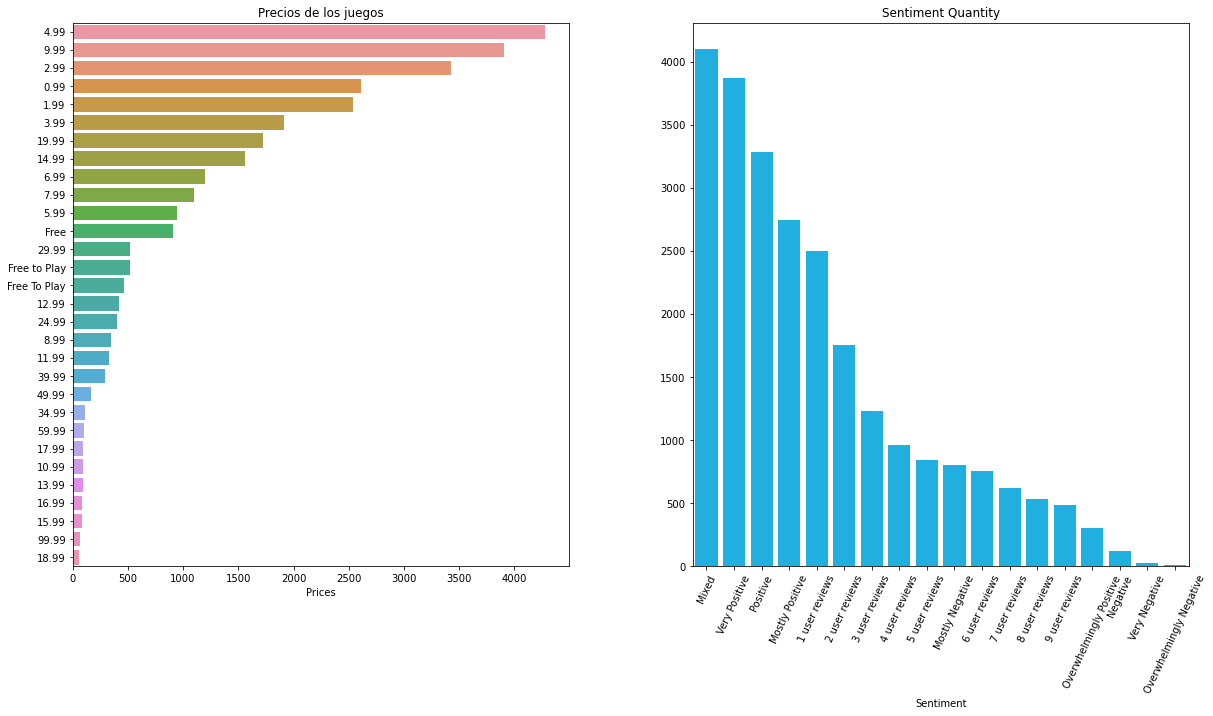

In [36]:
fig, (ax2, ax3) = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))


sns.countplot(y='price', data=data_games, order= data_games["price"].value_counts().index[:30,], ax = ax2)
ax2.set_xlabel('Prices', fontsize = 10)
ax2.set_ylabel('')
ax2.set_title('Precios de los juegos')
ax2.tick_params()

sns.countplot(x='sentiment', data=data_games,  order= data_games["sentiment"].value_counts().index[:20,],color='deepskyblue',ax = ax3)
ax3.set_xlabel('Sentiment', fontsize = 10)
ax3.set_ylabel('')
plt.xticks(rotation=65)
ax3.set_title('Sentiment Quantity')
ax3.tick_params()

plt.subplots_adjust(wspace=0.25)

In [37]:
data_games["sentiment"].value_counts(dropna=False)

NaN                        7182
Mixed                      4103
Very Positive              3868
Positive                   3281
Mostly Positive            2744
1 user reviews             2496
2 user reviews             1756
3 user reviews             1231
4 user reviews              964
5 user reviews              846
Mostly Negative             802
6 user reviews              756
7 user reviews              619
8 user reviews              537
9 user reviews              488
Overwhelmingly Positive     303
Negative                    123
Very Negative                29
Overwhelmingly Negative       7
Name: sentiment, dtype: int64

In [38]:
data_games[data_games.sentiment == 'Very Positive']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
27,Stainless Games Ltd,"[Action, Indie, Racing]",Carmageddon Max Pack,Carmageddon Max Pack,http://store.steampowered.com/app/282010/Carma...,1997-06-30,"[Racing, Action, Classic, Indie, Gore, 1990's,...",NaN,http://steamcommunity.com/app/282010/reviews/?...,"[Single-player, Multi-player, Steam Trading Ca...",9.99,False,282010,Stainless Games Ltd,Very Positive,NaN
40,Strategy First,[Strategy],Disciples II: Rise of the Elves,Disciples II: Rise of the Elves,http://store.steampowered.com/app/1630/Discipl...,2006-07-06,"[Strategy, Turn-Based Strategy, Fantasy, Turn-...",NaN,http://steamcommunity.com/app/1630/reviews/?br...,"[Single-player, Multi-player, Co-op]",6.99,False,1630,Strategy First,Very Positive,80
41,Blazing Griffin Ltd.,"[Action, Indie, RPG]",The Ship: Murder Party,The Ship: Murder Party,http://store.steampowered.com/app/2400/The_Shi...,2006-07-11,"[Multiplayer, Indie, Action, First-Person, Ste...",NaN,http://steamcommunity.com/app/2400/reviews/?br...,"[Single-player, Multi-player, Steam Trading Ca...",9.99,False,2400,Outerlight Ltd.,Very Positive,76
56,Introversion Software,"[Indie, Strategy]",DEFCON,DEFCON,http://store.steampowered.com/app/1520/DEFCON/,2006-09-29,"[Strategy, Indie, Multiplayer, Wargame, Cold W...",NaN,http://steamcommunity.com/app/1520/reviews/?br...,"[Single-player, Multi-player]",9.99,False,1520,Introversion Software,Very Positive,84
60,Unknown Worlds Entertainment,"[Casual, Indie]",Zen of Sudoku,Zen of Sudoku,http://store.steampowered.com/app/4900/Zen_of_...,2006-12-14,"[Casual, Indie, Puzzle]",NaN,http://steamcommunity.com/app/4900/reviews/?br...,[Single-player],Free,False,4900,Unknown Worlds Entertainment,Very Positive,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32108,Valve,[Action],Deathmatch Classic,Deathmatch Classic,http://store.steampowered.com/app/40/Deathmatc...,2001-06-01,"[Action, FPS, Multiplayer, Classic, Shooter, F...",NaN,http://steamcommunity.com/app/40/reviews/?brow...,"[Multi-player, Valve Anti-Cheat enabled]",4.99,False,40,Valve,Very Positive,NaN
32109,Valve,[Action],Half-Life: Blue Shift,Half-Life: Blue Shift,http://store.steampowered.com/app/130/HalfLife...,2001-06-01,"[FPS, Action, Sci-fi, Singleplayer, Shooter, A...",NaN,http://steamcommunity.com/app/130/reviews/?bro...,[Single-player],4.99,False,130,Gearbox Software,Very Positive,71
32110,Spiderweb Software,"[Strategy, RPG, Indie]",Geneforge 1,Geneforge 1,http://store.steampowered.com/app/200960/Genef...,2001-12-01,"[RPG, Indie, Strategy, Isometric, Turn-Based C...",NaN,http://steamcommunity.com/app/200960/reviews/?...,[Single-player],19.99,False,200960,Spiderweb Software,Very Positive,NaN
32114,Valve,[Action],Day of Defeat,Day of Defeat,http://store.steampowered.com/app/30/Day_of_De...,2003-05-01,"[FPS, World War II, Multiplayer, Action, Shoot...",NaN,http://steamcommunity.com/app/30/reviews/?brow...,"[Multi-player, Valve Anti-Cheat enabled]",4.99,False,30,Valve,Very Positive,79


* Parece una variable bastante confusa.

In [39]:
data_games["metascore"].value_counts(dropna=False)

NaN     29458
80.0      125
74.0      107
77.0      104
75.0      103
        ...  
24.0        1
20.0        1
95.0        1
27.0        1
30.0        1
Name: metascore, Length: 72, dtype: int64

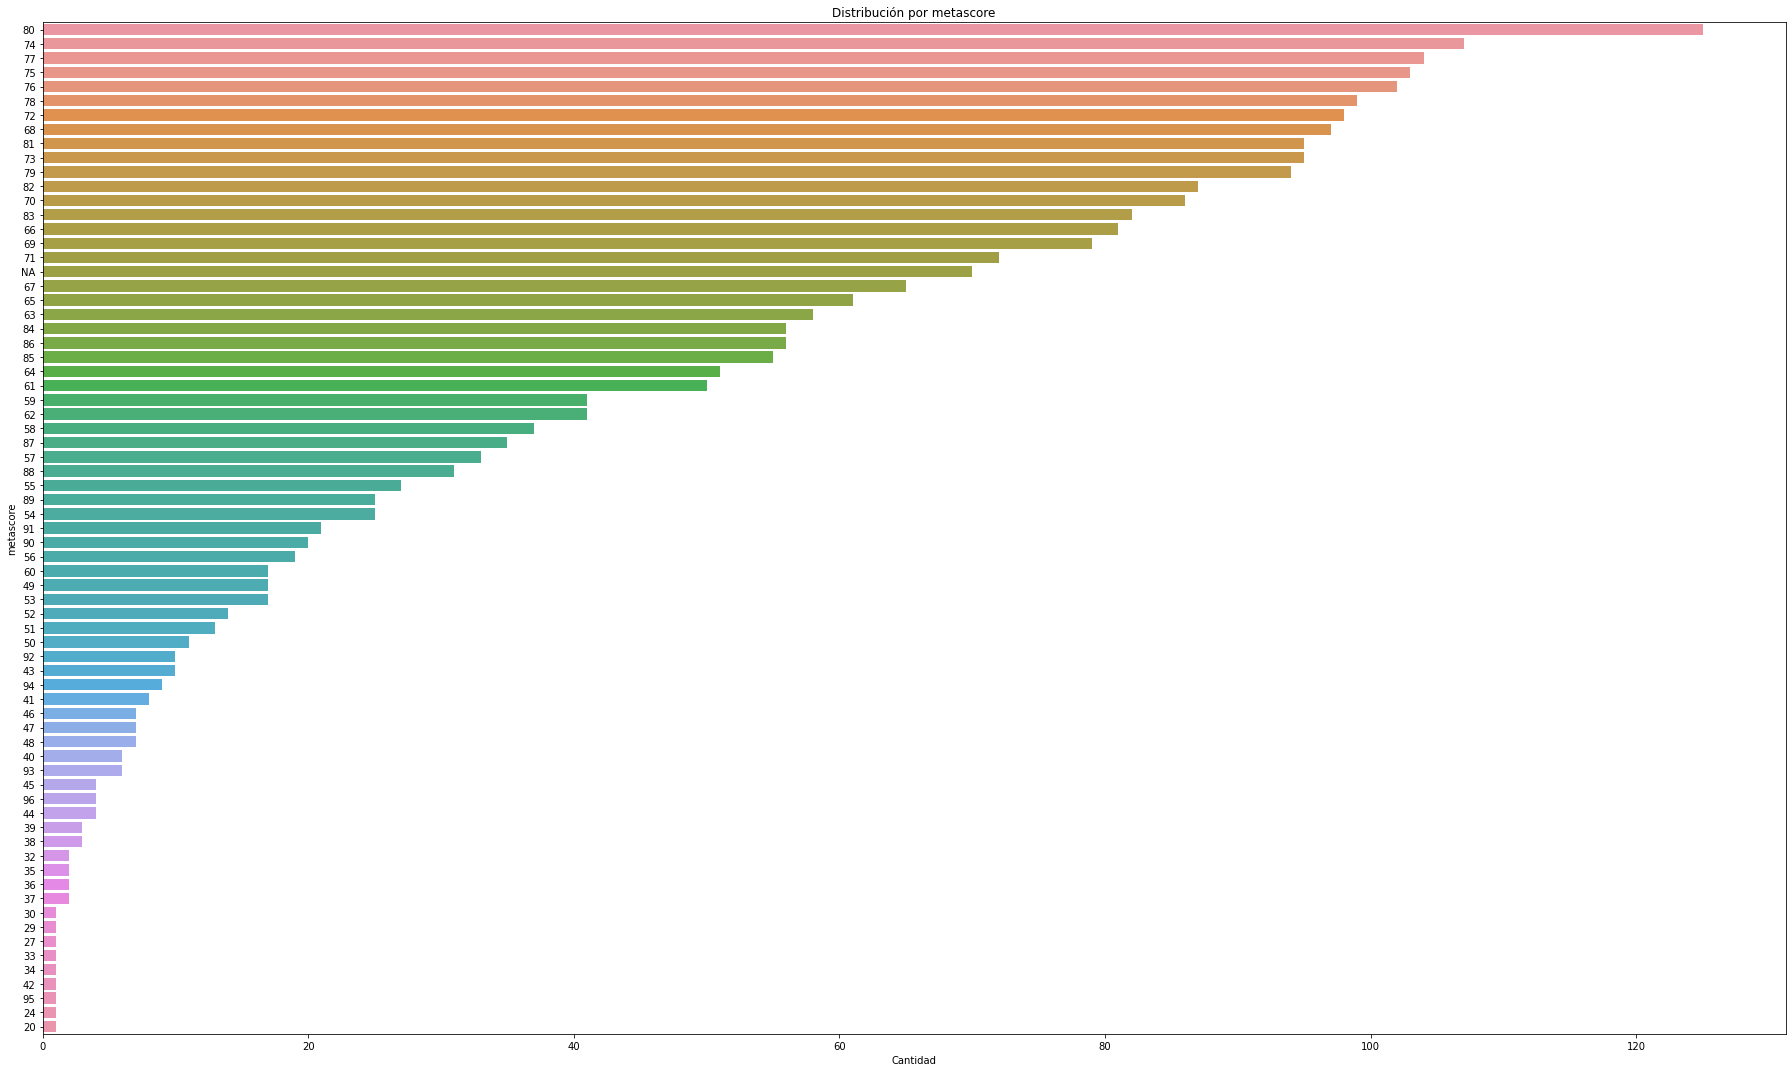

In [40]:
plt.figure(figsize=(25,15))
sns.countplot(data = data_games, y = "metascore", order= data_games["metascore"].value_counts().index[:80,]) 
plt.title("Distribución por metascore")
plt.xlabel("Cantidad")
plt.ylabel("metascore")
plt.tight_layout()
plt.show()

* De la misma forma que la columna sentiment, son columnas que dejan bastante que desear si lo que pretende uno es tomarlas como referencia.

In [41]:
data_reviews["username"].value_counts(dropna=False)

123                    213
Alex                   190
Chris                  155
Nick                   143
Matt                   137
                      ... 
Omal  ˙ ͜ʟ˙              1
crzydude004              1
Brodin [Praise Kek]      1
lugas                    1
PerfectPotato            1
Name: username, Length: 540341, dtype: int64

In [42]:
data_reviews[data_reviews.username == '123']

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
2951,123,484.1,69.0,271590,1,2017-12-30,"Don't buy. They don't bother fixing bugs, only...",False,107,76561198072738316,NaN,NaN
9404,123,34.2,81.0,35720,8,2017-12-29,An original platformer with beautiful medieval...,False,2,76561198049736588,NaN,NaN
13587,123,69.3,1.0,271590,2,2017-09-15,Nice game ever,False,1263,76561198170723669,NaN,1.0
17424,123,26.7,91.0,337000,8,2016-10-07,Game is garbage! Dont Buy it you will just be ...,False,458,76561197982600053,NaN,NaN
23996,123,19.4,98.0,389730,2,2017-12-26,first match i get into it puts me against play...,False,11,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
769784,123,702.0,74.0,252490,4,2016-03-14,This Game is crazy... you start at a beach wit...,True,4946,NaN,NaN,1.0
771147,123,436.6,41.0,221100,6,2015-06-10,Great survival game. The Early Access business...,True,3759,NaN,NaN,NaN
771314,123,324.3,85.0,221100,0,2015-06-04,It's all about surviving.\nThe only goal in th...,True,3803,NaN,NaN,NaN
775526,123,4189.3,17.0,252490,1,2015-04-03,Nab :D,True,6714,NaN,NaN,2.0


In [43]:
data_reviews[data_reviews.username == '123'].describe().round()

,hours,products,page_order,page,found_funny
count,213.0,213.0,213.0,213.0,39.0
mean,921.0,74.0,4.0,1356.0,5.0
std,1418.0,82.0,3.0,1751.0,21.0
min,0.0,1.0,0.0,1.0,1.0
25%,11.0,23.0,1.0,187.0,1.0
50%,118.0,48.0,3.0,715.0,1.0
75%,1460.0,86.0,6.0,2163.0,2.0
max,7898.0,542.0,9.0,16137.0,134.0


In [44]:
data_reviews[data_reviews.username == 'Alex']

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
1571,Alex,1.8,86.0,271860,1,2015-05-30,Давально интиресная игра,False,11,NaN,NaN,1.0
13020,Alex,0.1,115.0,531960,2,2016-10-03,woah!,False,27,76561198053274182,NaN,NaN
14130,Alex,7.8,174.0,225080,5,2017-05-19,"Glad I took the time to place this. Sure, the ...",False,137,NaN,NaN,NaN
16914,Alex,257.8,44.0,271590,0,2017-07-11,It's a very bad game for those who want to pla...,False,1766,NaN,NaN,NaN
19462,Alex,1.6,140.0,200710,6,2015-06-18,A parody of diablo,False,450,76561197973126243,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
766865,Alex,60.1,384.0,252490,3,2016-07-12,I don't play many of these types of survival g...,True,4233,NaN,NaN,NaN
766887,Alex,60.1,384.0,252490,3,2016-07-12,I don't play many of these types of survival g...,True,4238,NaN,NaN,NaN
769574,Alex,16.8,3.0,391540,3,2016-02-02,FIRST OFF THE GAME IS REEEEEEALY GOOD Toby NEX...,False,3914,76561198214642689,NaN,NaN
770379,Alex,18.8,283.0,221100,3,2015-07-06,Buggy doesnt even begin to describe.,True,3567,NaN,NaN,NaN


In [45]:
data_reviews[data_reviews.username == 'Alex'].describe().round()

,hours,products,page_order,page,found_funny
count,190.0,189.0,190.0,190.0,35.0
mean,136.0,235.0,4.0,973.0,2.0
std,406.0,398.0,3.0,1792.0,2.0
min,0.0,3.0,0.0,1.0,1.0
25%,6.0,52.0,2.0,61.0,1.0
50%,20.0,118.0,4.0,300.0,1.0
75%,77.0,265.0,7.0,969.0,3.0
max,3856.0,2313.0,9.0,14302.0,11.0


In [46]:
g=data_reviews.username.value_counts()
print("Han comentado", len(g), "usuarios en este dataset.\n")
g

Han comentado 540341 usuarios en este dataset.



123                    213
Alex                   190
Chris                  155
Nick                   143
Matt                   137
                      ... 
Omal  ˙ ͜ʟ˙              1
crzydude004              1
Brodin [Praise Kek]      1
lugas                    1
PerfectPotato            1
Name: username, Length: 540341, dtype: int64

In [47]:
data_reviews.username.describe()

count     779307
unique    540341
top          123
freq         213
Name: username, dtype: object

* Lo que puedo destacar de este pequeño analisis, hasta ahora, es que tenemos dos datasets en los cuales sin lugar a dudas tenemos una columna key que es la product_id(data_reviews) - id(data_games)
* Ademas hasta el momento no tenemos alguna columna que nos pueda dar un puntaje por juego de manera lógica. 
* Tambien pude estudiar los dos usuarios que más reviews tienen y tienen una cantidad excesivas de horas jugadas y juegos valorados, veremos que hacemos con estos usuarios despues.
* Sin dudas creo que podemos explorar muchísimas cosas a modo informativo, por cuestiones de tiempo creo que he estudiado las que me parecieron más relevantes hasta el momento. Me parece prudente empezar a tocar los datasets por lo que voy a crear dos copias para tener los originales disponibles por las dudas.


In [48]:
data_reviews_copia = data_reviews.copy()
data_games_copia = data_games.copy()

In [49]:
data_reviews_copia.username.value_counts()

123                    213
Alex                   190
Chris                  155
Nick                   143
Matt                   137
                      ... 
Omal  ˙ ͜ʟ˙              1
crzydude004              1
Brodin [Praise Kek]      1
lugas                    1
PerfectPotato            1
Name: username, Length: 540341, dtype: int64

In [50]:
data_reviews_copia.user_id.value_counts()

76561198011965365    114
76561198094803808     88
76561197969749884     70
76561198094321628     62
76561198073092169     57
                    ... 
76561198078243116      1
76561197998139498      1
76561198358198007      1
76561198190405585      1
76561198180308011      1
Name: user_id, Length: 262058, dtype: int64

In [51]:
data_reviews_copia.user_id.describe()

count                317340
unique               262058
top       76561198011965365
freq                    114
Name: user_id, dtype: object

* Creo que podemos asegurar que no todos los usuarios tienen su propio USER_ID, por lo que vamos a tener que crearle un ID a cada uno de ellos como asi tambien alguna forma para calificar la review de una manera más lógica.

In [52]:
data_r_user = data_reviews_copia.copy()
data_r_user.drop(columns=['date', 'products','page_order','text','early_access','compensation','found_funny','page', 'user_id'], inplace=True)
data_r_user

,username,hours,product_id
0,Chaos Syren,0.1,725280
1,Ariman1,13.2,328100
2,freakfantom,0.1,725280
3,The_Cpt_FROGGY,7.8,631920
4,the_maker988,8.2,35140
...,...,...,...
779302,Vidaar,783.5,252490
779303,Nikolai Belinski,55.1,252490
779304,RancorZealot,203.5,252490
779305,Jerry,139.8,252490


In [53]:
data_r_user.isna().sum()

username         0
hours         2637
product_id       0
dtype: int64

* Despues de limpiar las demás columnas, vamos a crearle un ID a cada usuario para una mejor práctica para el modelo.


In [54]:
usuarios=data_r_user['username'].unique()
userid_prueba=pd.DataFrame(usuarios,columns=['username'])   
finRango=len(userid_prueba)+1
id_user=np.array(range(1,finRango,1))
userid_prueba['id_user']=id_user
userid_prueba

,username,id_user
0,Chaos Syren,1
1,Ariman1,2
2,freakfantom,3
3,The_Cpt_FROGGY,4
4,the_maker988,5
...,...,...
540336,Seikleja,540337
540337,KindAlcoholic,540338
540338,SepticFalcon,540339
540339,RancorZealot,540340


In [55]:
data_r_user=data_r_user.merge(userid_prueba, left_on='username', right_on='username')
data_r_user

,username,hours,product_id,id_user
0,Chaos Syren,0.1,725280,1
1,Ariman1,13.2,328100,2
2,Ariman1,0.5,521230,2
3,Ariman1,2.0,493980,2
4,freakfantom,0.1,725280,3
...,...,...,...,...
779302,Seikleja,80.8,252490,540337
779303,KindAlcoholic,1303.6,252490,540338
779304,SepticFalcon,334.9,252490,540339
779305,RancorZealot,203.5,252490,540340


In [56]:
data_r_user.isna().sum()

username         0
hours         2637
product_id       0
id_user          0
dtype: int64

* Lo próximo que voy hacer es idear una columna que sea calificativa para el juego, para esto, creo que nuestra mejor opción es que esta columna este ligada a la cantidad de horas que un usuario jugó a ese juego. Pasando en limpio, voy a seguir la linea de que si un usuario ha invertido más horas en un juego que en otro significa que ese juego le gusto más que al que jugó menos.

In [57]:
data_r_user.hours.describe().round()

count    776670.0
mean        112.0
std         390.0
min           0.0
25%           4.0
50%          15.0
75%          60.0
max       28164.0
Name: hours, dtype: float64

In [58]:
data_horas = data_r_user.copy()
data_horas = data_horas[(data_horas.hours>=1)&(data_horas.hours<=500)]
data_horas

,username,hours,product_id,id_user
1,Ariman1,13.2,328100,2
3,Ariman1,2.0,493980,2
5,The_Cpt_FROGGY,7.8,631920,4
6,The_Cpt_FROGGY,7.3,482440,4
7,The_Cpt_FROGGY,4.7,736860,4
...,...,...,...,...
779299,"Kiss me, Baby!",360.0,252490,540334
779300,ZJbroski,18.7,252490,540335
779302,Seikleja,80.8,252490,540337
779304,SepticFalcon,334.9,252490,540339


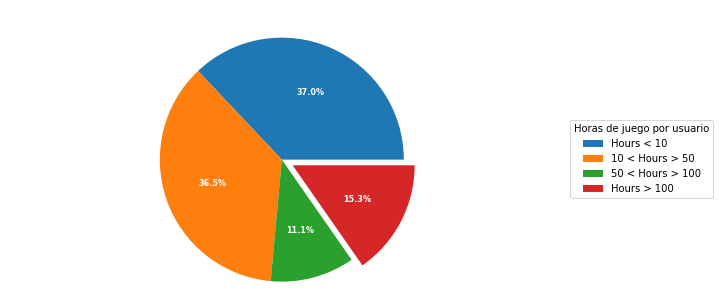

In [59]:
horasmenor10=len(data_horas[(data_horas.hours>=1)&(data_horas.hours<=10)])
horas10a50=len(data_horas[(data_horas.hours>10)&(data_horas.hours<=50)])
horas50a100=len(data_horas[(data_horas.hours>50)&(data_horas.hours<=100)])
horasmayor100=len(data_horas[(data_horas.hours>100)&(data_horas.hours<=500)])

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

recipe = ['Hours < 10', '10 < Hours > 50', '50 < Hours > 100', 'Hours > 100']

data = [horasmenor10, horas10a50, horas50a100, horasmayor100]
ingredients = ['Hours < 10', '10 < Hours > 50', '50 < Hours > 100', 'Hours > 100']
explode = (0, 0, 0, 0.1)



wedges, texts, autotexts = ax.pie(data, autopct='%1.1f%%',
                                  textprops=dict(color="w"),explode=explode)

ax.legend(wedges, ingredients,
          title="Horas de juego por usuario",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Horas de juego por usuario", color="w")
ax.axis('equal')

plt.show()

In [60]:
print("horas 1-10 =",horasmenor10,
      "\nhoras 10-50 =",horas10a50, 
      "\nhoras 50-100 =",horas50a100,
      "\nhoras 100-500 =",horasmayor100)
print("\nHemos filtrado", horasmenor10 + horas10a50 + horas50a100 + horasmayor100, "por sobre", len(data_reviews.username), ".")
print('Hemos eliminado una cantidad de', (data_reviews.shape[0] - data_horas.shape[0]), 'instancias por detectarlo como outliers.')

horas 1-10 = 245593 
horas 10-50 = 241892 
horas 50-100 = 73892 
horas 100-500 = 101509

Hemos filtrado 662886 por sobre 779307 .
Hemos eliminado una cantidad de 116421 instancias por detectarlo como outliers.


* Hemos sacado aproximadamente 110.000 reviews. Estos usuario fueron sacados ya que o han jugado menos de 1 hora a algun juego o han jugado más de 500 horas, creo que este parametro me parece prudente para trabajar con datos serios.


* Lo siguiente que voy a implementar va ser una nueva columna llamada "score" donde vamos a colocarle un puntaje a cada review tomando en cuenta su cantidad de horas jugadas.

In [61]:
data_horas['score']=0 #llena de 0 por ahora
data_horas.head()

,username,hours,product_id,id_user,score
1,Ariman1,13.2,328100,2,0
3,Ariman1,2.0,493980,2,0
5,The_Cpt_FROGGY,7.8,631920,4,0
6,The_Cpt_FROGGY,7.3,482440,4,0
7,The_Cpt_FROGGY,4.7,736860,4,0


In [62]:
import warnings
warnings.filterwarnings('ignore')

rank=[10,20,30,40,50,60,70,80,90]

for valor in rank:
    data_horas['score'][(data_horas.hours>(valor-10)) & (data_horas.hours<=valor)]=(valor/10)

data_horas['score'][(data_horas.hours>=100)]=10
data_horas

,username,hours,product_id,id_user,score
1,Ariman1,13.2,328100,2,2
3,Ariman1,2.0,493980,2,1
5,The_Cpt_FROGGY,7.8,631920,4,1
6,The_Cpt_FROGGY,7.3,482440,4,1
7,The_Cpt_FROGGY,4.7,736860,4,1
...,...,...,...,...,...
779299,"Kiss me, Baby!",360.0,252490,540334,10
779300,ZJbroski,18.7,252490,540335,2
779302,Seikleja,80.8,252490,540337,9
779304,SepticFalcon,334.9,252490,540339,10


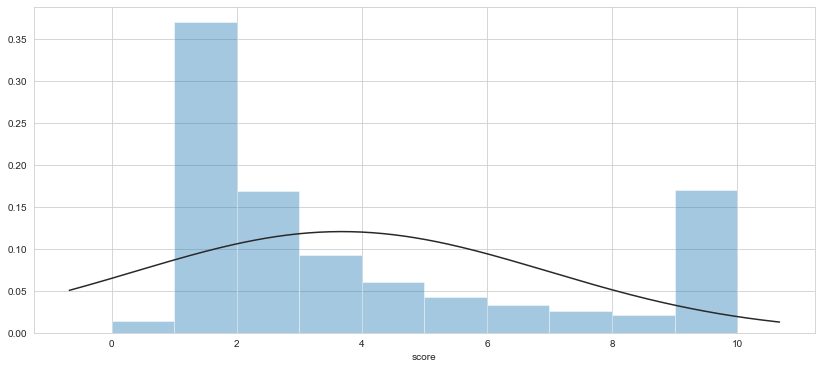

In [63]:
sns.set_style("whitegrid")
data = data_horas.score
ax = sns.distplot(data, fit=norm, kde=False, bins=10)

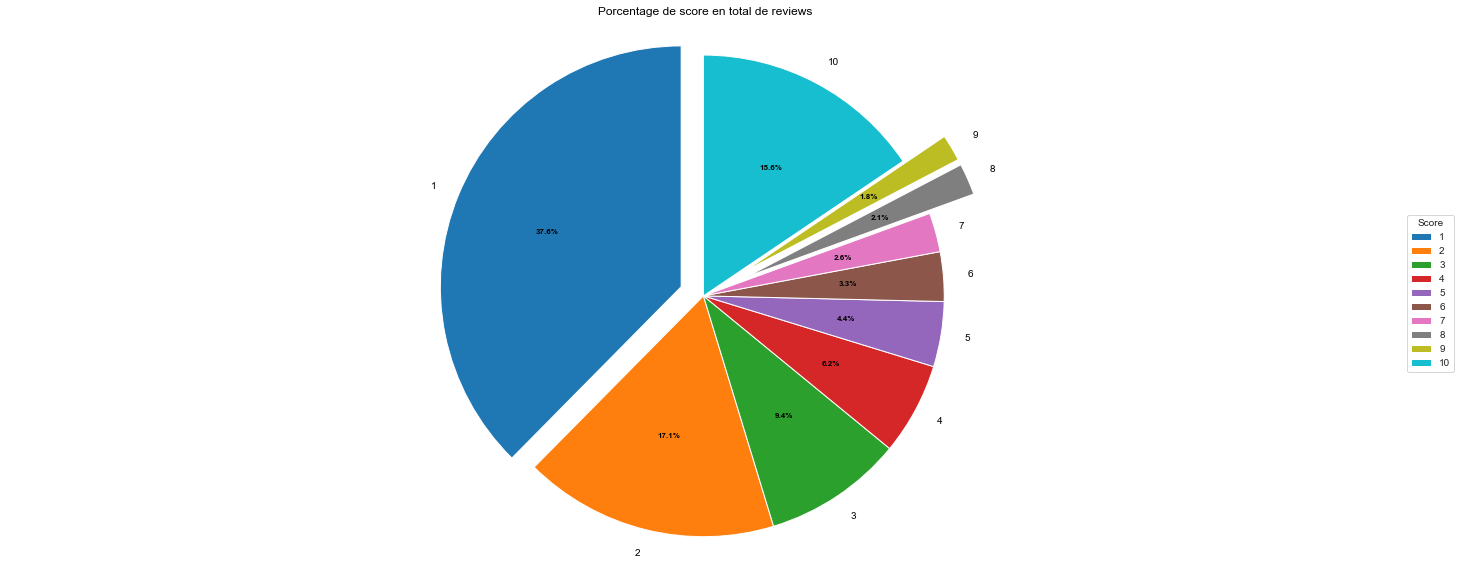

In [64]:
score_1=len(data_horas[data_horas.score==1])
score_2=len(data_horas[data_horas.score==2])
score_3=len(data_horas[data_horas.score==3])
score_4=len(data_horas[data_horas.score==4])
score_5=len(data_horas[data_horas.score==5])
score_6=len(data_horas[data_horas.score==6])
score_7=len(data_horas[data_horas.score==7])
score_8=len(data_horas[data_horas.score==8])
score_9=len(data_horas[data_horas.score==9])
score_10=len(data_horas[data_horas.score==10])


fig, ax = plt.subplots(figsize=(25, 10), subplot_kw=dict(aspect="equal"))

recipe = [1,2,3,4,5,6,7,8,9,10]

data = [score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10]
ingredients = [1,2,3,4,5,6,7,8,9,10]
explode = (0.1,0,0,0,0,0,0,0.2,0.2,0)



wedges, texts, autotexts = ax.pie(data, autopct='%1.1f%%', labels= recipe,
                                  textprops=dict(color="black"),explode=explode, startangle=90)

ax.legend(wedges, ingredients,
          title="Score",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Porcentage de score en total de reviews", color="black")
ax.axis('equal')

plt.show()

In [65]:
 print("SCORE 1 - 37.6 % \nSCORE 2 - 17.1 %\nSCORE 3 - 9.4 %\nSCORE 4 - 6.2 %\nSCORE 5 - 4.4 %\nSCORE 6 - 3.3 %\nSCORE 7 - 2.6 %\nSCORE 8 - 2.1 %\nSCORE 9 - 1.8 %\nSCORE 10 - 15.6 %")

SCORE 1 - 37.6 % 
SCORE 2 - 17.1 %
SCORE 3 - 9.4 %
SCORE 4 - 6.2 %
SCORE 5 - 4.4 %
SCORE 6 - 3.3 %
SCORE 7 - 2.6 %
SCORE 8 - 2.1 %
SCORE 9 - 1.8 %
SCORE 10 - 15.6 %




* Es importante recalcar a este punto, que de acuerdo a la cantidad de horas jugadas se creó una nueva columna "Score", donde en estos dos últimos gráficos se ha podido observar la distribución. A simple vista se puede ver que la mayoria de los usuarios han jugado más de 100 horas y entre 1 a 20 horas aproximadamente. Me parece prudente hacer una mini exploración de datos con cada score para entender un poco mas el nuevo dataset con el que estamos trabajando.

In [66]:
data_horas = data_horas.drop(columns=["hours"])
data_horas

,username,product_id,id_user,score
1,Ariman1,328100,2,2
3,Ariman1,493980,2,1
5,The_Cpt_FROGGY,631920,4,1
6,The_Cpt_FROGGY,482440,4,1
7,The_Cpt_FROGGY,736860,4,1
...,...,...,...,...
779299,"Kiss me, Baby!",252490,540334,10
779300,ZJbroski,252490,540335,2
779302,Seikleja,252490,540337,9
779304,SepticFalcon,252490,540339,10


In [67]:
data_horas[data_horas.score == 10]

,username,product_id,id_user,score
148,Hanzo,287290,16,10
166,Harry,377160,17,10
174,Harry,213850,17,10
183,Harry,221100,17,10
185,Harry,252490,17,10
...,...,...,...,...
779293,HagDawg,252490,540328,10
779296,TheCDJohnson,252490,540331,10
779299,"Kiss me, Baby!",252490,540334,10
779304,SepticFalcon,252490,540339,10


In [68]:
data_horas[data_horas.score == 1]

,username,product_id,id_user,score
3,Ariman1,493980,2,1
5,The_Cpt_FROGGY,631920,4,1
6,The_Cpt_FROGGY,482440,4,1
7,The_Cpt_FROGGY,736860,4,1
8,The_Cpt_FROGGY,493540,4,1
...,...,...,...,...
779247,nothingreal,252490,540283,1
779254,Perra,252490,540289,1
779258,Februmm,252490,540293,1
779262,Icyhate,252490,540297,1


In [69]:
data_horas[data_horas.score == 10]["product_id"].value_counts().to_frame()

,product_id
440,5122
252490,3665
377160,3541
49520,3027
271590,2799
...,...
363530,1
248550,1
31700,1
584370,1


In [70]:
data_horas[data_horas.score == 1]["product_id"].value_counts().to_frame()

,product_id
221910,1873
440,1518
225080,1493
232430,1145
417860,1074
...,...
697660,1
308180,1
633600,1
692270,1


In [71]:
data_horas[data_horas.product_id == "440"]

,username,product_id,id_user,score
310,Ian,440,35,5
1541,Harambe,440,323,10
2239,Blyatman,440,487,10
2275,Zach,440,492,10
2690,Zer0,440,569,2
...,...,...,...,...
522581,Dirtygoggles,440,309294,10
522582,CYK0,440,309295,2
522583,the guy,440,309296,1
522584,Garan,440,309297,10


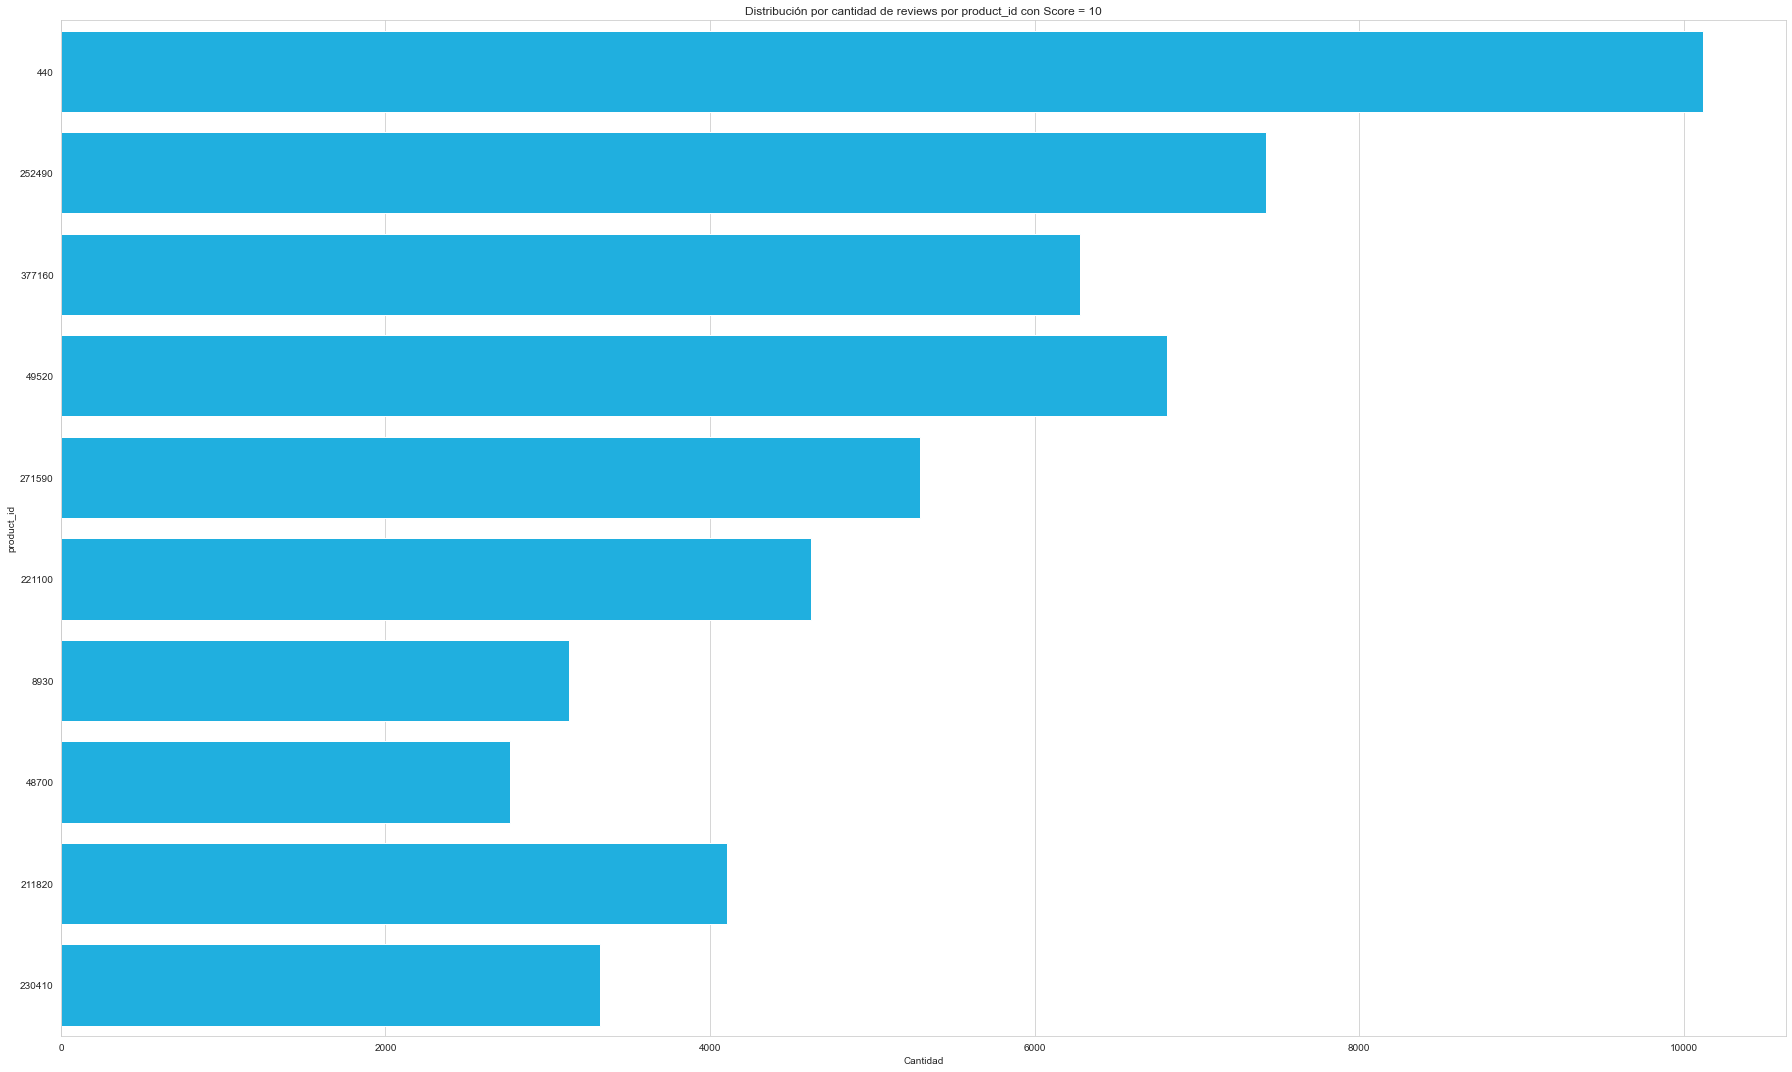

In [72]:
plt.figure(figsize=(25,15))
sns.countplot(data = data_horas, y = "product_id", order= data_horas[data_horas.score == 10]["product_id"].value_counts(ascending=False).index[:10,], color='deepskyblue') 
plt.title("Distribución por cantidad de reviews por product_id con Score = 10")
plt.xlabel("Cantidad")
plt.ylabel("product_id")
plt.tight_layout()
plt.show()

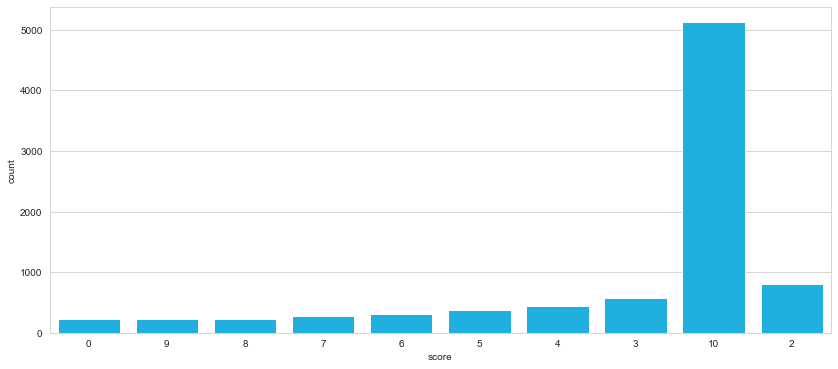

In [73]:
sns.countplot(x = 'score',
              data = data_horas[data_horas.product_id == "440"],
              order = data_horas['score'].value_counts(ascending=True).index[:10,],  color='deepskyblue')
plt.show()

* Me llamó la atencion este juego ya que tiene 5000 respuestas con 10 puntos y 1000 con 1 punto 

In [74]:
diez_score10 = data_horas[data_horas.score == 10]["product_id"].value_counts().to_frame().reset_index().rename(columns={"index":"product_id","product_id":"Cuenta"}).head(10)
diez_score10

,product_id,Cuenta
0,440,5122
1,252490,3665
2,377160,3541
3,49520,3027
4,271590,2799
5,221100,1873
6,8930,1762
7,48700,1733
8,211820,1721
9,230410,1616


# DATA_GAMES

In [75]:
# estudiamos el dataset de data_games
data_games_copia

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",NaN,NaN
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,NaN,NaN
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,NaN,NaN
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",1 user reviews,NaN


In [76]:
# observamos sus nulos
data_games_copia.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

* Muchos valores nulos.

In [77]:
datag = data_games_copia.copy()

In [78]:
datag.drop(columns=['title','publisher','genres','release_date','tags','discount_price','reviews_url','specs','price','early_access','developer','sentiment','metascore'], inplace=True)
datag

,app_name,url,id
0,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,761140
1,Ironbound,http://store.steampowered.com/app/643980/Ironb...,643980
2,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,670290
3,弹炸人2222,http://store.steampowered.com/app/767400/2222/,767400
4,Log Challenge,http://store.steampowered.com/app/773570/Log_C...,773570
...,...,...,...
32130,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,773640
32131,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,733530
32132,Russian Roads,http://store.steampowered.com/app/610660/Russi...,610660
32133,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,658870


In [79]:
datag.isna().sum()

app_name    2
url         0
id          2
dtype: int64

* Hay demasiados nulos en columnas que la erdad pienso que no vamos a necesitar para realizar nuestro modelo por lo cual procedo a eliminarlos.

In [80]:
datag.dropna(inplace=True)
datag.isna().sum()

app_name    0
url         0
id          0
dtype: int64

* Desde el comienzo contamos con dos datasets de los cuales en uno detallan todas las reviews y en el otro los juegos. Haciendo un analisis exploratorio encontramos en ambos datasets una columna "key" donde se puede crear una relacion many-to-one. Lo proximo que vamos hacer es renombrar la siguiente columna para poder crear un merge en el futuro.


In [81]:
# Vamos a cambiarle ahora el nombre al id por "product id", así podemos hacer un merge más adelante de los dataset a 1 principal
datag.rename(columns={'id': 'product_id'}, inplace=True)
datag.head()


,app_name,url,product_id
0,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,761140
1,Ironbound,http://store.steampowered.com/app/643980/Ironb...,643980
2,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,670290
3,弹炸人2222,http://store.steampowered.com/app/767400/2222/,767400
4,Log Challenge,http://store.steampowered.com/app/773570/Log_C...,773570


# PARTE B - MODELO DE MARCHING LEARNING - Desarrollo del Sistema de Recomendación

* Una vez terminado nuestro analisis exploratorio de datos, procedemos a empezar nuestro modelo de Sistemas de Recomendación. En este caso voy a tener en cuenta el notebook de la bitacora #38 ya que me parece que explica claro como hacer el modelo y como encarar el tema. 

In [82]:
reader = Reader(rating_scale=(1, 10))

In [83]:
data_horas.head()

,username,product_id,id_user,score
1,Ariman1,328100,2,2
3,Ariman1,493980,2,1
5,The_Cpt_FROGGY,631920,4,1
6,The_Cpt_FROGGY,482440,4,1
7,The_Cpt_FROGGY,736860,4,1


In [84]:
df = data_horas[["id_user", "product_id","score"]]
df

,id_user,product_id,score
1,2,328100,2
3,2,493980,1
5,4,631920,1
6,4,482440,1
7,4,736860,1
...,...,...,...
779299,540334,252490,10
779300,540335,252490,2
779302,540337,252490,9
779304,540339,252490,10


In [85]:
data = Dataset.load_from_df(df[["id_user", "product_id","score"]], reader)

In [86]:
trainset, testset = train_test_split(data, test_size=.20, random_state=42)

In [87]:
testset

[(74694, '259080', 2.0),
 (118062, '319630', 3.0),
 (532387, '252490', 10.0),
 (167295, '211820', 10.0),
 (518924, '40800', 4.0),
 (210669, '274940', 1.0),
 (124621, '219150', 1.0),
 (400085, '514900', 2.0),
 (61691, '205950', 4.0),
 (169224, '221380', 2.0),
 (197394, '377160', 10.0),
 (334852, '242920', 8.0),
 (238180, '227300', 3.0),
 (292415, '433850', 10.0),
 (104001, '413420', 4.0),
 (219630, '432370', 1.0),
 (500649, '306130', 2.0),
 (124685, '256460', 3.0),
 (91852, '258220', 1.0),
 (192602, '304930', 4.0),
 (446391, '212680', 10.0),
 (402349, '447530', 2.0),
 (523003, '241600', 5.0),
 (376564, '431240', 6.0),
 (94352, '346630', 1.0),
 (6855, '245150', 1.0),
 (401572, '324810', 1.0),
 (392513, '346110', 6.0),
 (196464, '377160', 10.0),
 (530272, '49520', 10.0),
 (123314, '113200', 4.0),
 (429253, '250620', 1.0),
 (260331, '359550', 1.0),
 (40358, '224600', 1.0),
 (33611, '200710', 4.0),
 (77484, '200510', 9.0),
 (7561, '402020', 1.0),
 (538292, '252490', 8.0),
 (343805, '241560'

**SVD**

* Siguiendo la bitácora #38, vamos a entrenar un algoritmo SVD, explorando sus parámetros y su funcionamiento.

In [88]:
%%time
#Entrenamos sobre el trainset
from surprise import SVD
algo = SVD()
algo.fit(trainset)

Wall time: 41.4 s


In [89]:
#Hacemos las predicciones sobre el testset 
predictions = algo.test(testset)

In [90]:
predictions[1]

Prediction(uid=118062, iid='319630', r_ui=3.0, est=2.5598792366174448, details={'was_impossible': False})

In [91]:
#Probamos
algo.predict(45948,268500)

Prediction(uid=45948, iid=268500, r_ui=None, est=3.6729240365975997, details={'was_impossible': False})

* Vamos a utilizar la métrica de accuracy mediante el RMSE.

In [92]:
accuracy.rmse(predictions)

RMSE: 2.7094


2.709421482903247

* Aqui tenemos nuestro primer RMSE, donde el objetivo a partir de acá va ser mejorarlo mediante la optimización de hiperparámetros y mejorando la métrica. 
* Vamos a implementar un gridsearch con aproximadamente el 50% de las instancias para ver si mejora.

In [93]:

N_filas = 300000 

data_2 = Dataset.load_from_df(df[["id_user", "product_id","score"]][:N_filas], reader)
trainset_2, testset_2 = train_test_split(data_2, test_size=.20, random_state=42)
algo_2 = SVD()
algo_2.fit(trainset_2)
predictions_2 = algo_2.test(testset_2)
accuracy.rmse(predictions_2)

RMSE: 2.6438


2.6438314198051565

* No se si hemos tenido alguna mejora considerable, pero baja un poco.

In [94]:
%%time
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[1,2,3],'n_epochs': [25,27,30], 'lr_all': [0.0015, 0.002],
              'reg_all': [0.01, 0.015,0.02]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs = -1, joblib_verbose=5)
gs.fit(data_2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.3min


Wall time: 10min 5s


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 10.0min finished


In [95]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

2.6394630311054743
{'n_factors': 1, 'n_epochs': 25, 'lr_all': 0.002, 'reg_all': 0.02}


In [96]:
algo_3 = SVD(n_factors =1,n_epochs=25,lr_all=0.002,reg_all=0.02)
algo_3.fit(trainset_2)
predictions_3 = algo_3.test(testset_2)
accuracy.rmse(predictions_3)

RMSE: 2.6443


2.6442522296715905

* Leve mejora

**Intentamos el algoritmo SVD++**

In [97]:
%%time

from surprise import SVDpp
algo_pp = SVDpp()
algo_pp.fit(trainset)

predictions_pp = algo_pp.test(testset)

#Probamos
algo_pp.predict(45948,268500)

Wall time: 1min 22s


Prediction(uid=45948, iid=268500, r_ui=None, est=3.6729240365975997, details={'was_impossible': False})

In [98]:
accuracy.rmse(predictions_pp)

RMSE: 2.9891


2.9890866032550374

In [99]:

N_filas = 300000 

data_2 = Dataset.load_from_df(df[["id_user", "product_id","score"]][:N_filas], reader)
trainset_2, testset_2 = train_test_split(data_2, test_size=.20, random_state=42)
algo_pp2 = SVDpp()
algo_pp2.fit(trainset_2)
predictions_2 = algo_pp2.test(testset_2)
accuracy.rmse(predictions_2)

RMSE: 2.8971


2.897052427085293

In [ ]:
%%time
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[1,2,3],'n_epochs': [25,27,30], 'lr_all': [0.0015, 0.002],
              'reg_all': [0.01, 0.015,0.02]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=5, n_jobs = -1, joblib_verbose=5)
gs.fit(data_2)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.8min


In [ ]:
algo_pp2 = SVDpp(n_factors = 1, n_epochs= 27, lr_all= 0.002, reg_all= 0.015)
algo_pp2.fit(trainset)

predictions_pp2 = algo_pp2.test(testset)

accuracy.rmse(predictions_pp2)

* Iniciamos las recomendaciones a dos usuarios a modo de ejemplo con juegos valorados como 7 o más.

***Usuario ZAON.***

In [ ]:
data_horas[data_horas.username == 'Zaon']

In [ ]:
usuario = 418459
rating = 7 #para que sean todos los juegos con score mayor a 7

# Filtramos
df_usuario = data_horas[(data_horas['id_user'] == usuario) & (data_horas['score'] >= rating)]

#Reseteamos el index
df_usuario = df_usuario.reset_index(drop=True)

# hacemos un merge
df_usuario = pd.merge(left=df_usuario,right=datag, left_on='product_id', right_on='product_id')

# Listamos el resultado
df_usuario

In [ ]:
## Usamos el mismo código que en la bitácora #38

recomendaciones_usuario =datag.copy()
recomendaciones_usuario.set_index('product_id',inplace=True)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

In [ ]:
usuario_vistas = data_horas[data_horas['id_user'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()


In [ ]:
recomendaciones_usuario.drop(usuario_vistas.product_id,inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

In [ ]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)

In [ ]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head()

***Usuario Alex.***

In [ ]:
data_horas[data_horas.username == 'Alex']

In [ ]:
usuario = 1557
rating = 7 #para que sean todos los juegos con score mayor a 7

# Filtramo
df_usuario = data_horas[(data_horas['id_user'] == usuario) & (data_horas['score'] >= rating)]

#Reseteamos el index
df_usuario = df_usuario.reset_index(drop=True)

# hacemos un merge
df_usuario = pd.merge(left=df_usuario,right=datag, left_on='product_id', right_on='product_id')

# Listamos el resultado
df_usuario

In [ ]:
## Usamos el mismo código que en la bitácora #38

recomendaciones_usuario =datag.copy()
recomendaciones_usuario.set_index('product_id',inplace=True)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

In [ ]:
usuario_vistas = data_horas[data_horas['id_user'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

In [ ]:
recomendaciones_usuario.drop(usuario_vistas.product_id,inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

In [ ]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario[10:20]

# Conclusión 